In [1]:
import numpy as np
import pylab as plt
import torch
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import swyft
import random
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader



DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

# Define simulator parameters
f_low = 10
f_high = 1024
N_bins = 4096
freq = np.linspace(f_low, f_high, N_bins)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=len(freq), bounds=None):
        super().__init__()
        
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(f_low, f_high, N_bins)
        self.sample_z = swyft.RectBoundSampler([stats.uniform(-12,5), #omega
                                                stats.uniform(0,5)], #alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = 10**z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m)
        #x = graph.node("x", lambda m: m + 0, m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

In [4]:
# Sample from Simulator

n_samples = 10000
fref = 25
CE_PSD = np.genfromtxt("data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
sigma = sim.sigma

samples = sim.sample(n_samples) 

x_samples = np.log10(np.abs(samples['x']))
m_samples = np.log10(np.abs(samples['m']))

scaler_x = StandardScaler()
scaler_m = StandardScaler()

x_samples = scaler_x.fit_transform(x_samples)
samples['x'] = x_samples

obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
obs['x'] = scaler_x.fit_transform(np.log10(np.abs(samples['x'])))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
class VAE(swyft.SwyftModule):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder layers (same as before, but with mu and logvar layers)
        self.encoder_fc1 = nn.Linear(4096, 2048)
        self.encoder_ln1 = nn.LayerNorm(2048)

        self.encoder_fc2 = nn.Linear( 2048, 1024)
        self.encoder_ln2 = nn.LayerNorm(1024)

        self.encoder_fc3 = nn.Linear(1024, 512)
        self.encoder_ln3 = nn.LayerNorm(512)

        self.encoder_fc4 = nn.Linear(512, 256)
        self.encoder_ln4 = nn.LayerNorm(256)

        self.encoder_fc5 = nn.Linear( 256, 128)
        self.encoder_ln5 = nn.LayerNorm(128)

        self.encoder_fc6 = nn.Linear(128, 64)
        self.encoder_ln6 = nn.LayerNorm(64)

        self.encoder_fc7 = nn.Linear(64, 32)
        self.encoder_ln7 = nn.LayerNorm(32)
        
        # Latent space mean and log variance
        self.fc_mu = nn.Linear(32,16) # bigger latent space improved learning 
        self.fc_logvar = nn.Linear(32, 16)
        
        self.dropout = nn.Dropout(0.1)

        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 16, num_params = 2, varnames = 'z') 
    
        self.logratios2 = swyft.LogRatioEstimator_Ndim(
            num_features=16,
            marginals=[(0, 1)],
            varnames='z',
            num_blocks=4
        )

    def encode(self, x):
        x = F.leaky_relu(self.encoder_ln1(self.encoder_fc1(x)))
        x = F.leaky_relu(self.encoder_ln2(self.encoder_fc2(x)))
        x = F.leaky_relu(self.encoder_ln3(self.encoder_fc3(x)))
        x = F.leaky_relu(self.encoder_ln4(self.encoder_fc4(x)))
        x = F.leaky_relu(self.encoder_ln5(self.encoder_fc5(x)))
        x = F.leaky_relu(self.encoder_ln6(self.encoder_fc6(x)))
        x = F.leaky_relu(self.encoder_ln7(self.encoder_fc7(x)))
        
    
        # Get the mean and log variance for the latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: z = mu + sigma * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # random noise
        z = mu + eps * std # latent variable
        return z


    def forward(self, A,B):
        # Forward pass: encode, reparameterize, decode
        mu, logvar = self.encode(A['x'])
        z = self.reparameterize(mu, logvar)
        z = self.dropout(z)
        logratios1= self.logratios1(z, B['z'])
        logratios2 = self.logratios2(z, B['z'])
        return logratios1, logratios2
        
    



In [6]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers


dm = swyft.SwyftDataModule(samples, val_fraction = 0.2, batch_size = 128)

lr_monitor = LearningRateMonitor(logging_interval='step')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta = 0., patience=3, verbose=False, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='./logs/', filename='rings_{epoch}_{val_loss:.2f}_{train_loss:.2f}', mode='min')
logger = pl_loggers.TensorBoardLogger(save_dir='./logs/', name='VAE_logs', version=None)

trainer = swyft.SwyftTrainer(accelerator = 'cpu', auto_lr_find=True, logger=logger, callbacks=[lr_monitor, early_stopping_callback, checkpoint_callback], precision=64)
network = VAE()
trainer.fit(network, dm)



GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint

   | Name        | Type                   | Params
--------------------------------------------------------
0  | encoder_fc1 | Linear                 | 8.4 M 
1  | encoder_ln1 | LayerNo

Sanity Checking: 0it [00:00, ?it/s]

/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataload

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: ./logs/VAE_logs/version_8/checkpoints/epoch=19-step=1260.ckpt


/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(sel

In [7]:
# Define priors
omega_prior = stats.uniform(-12, 5)  # Log-uniform distribution for omega
alpha_prior = stats.uniform(0,5)            # Uniform distribution for alpha

obs = swyft.Sample(x=samples['x'][0], z=samples['z'][0] ) 
# Sample 1000 points from the priors
z_omega = omega_prior.rvs(20000)
z_alpha = alpha_prior.rvs(20000)

z_samps = np.column_stack((z_omega, z_alpha))

# Create prior samples
prior_samples = swyft.Samples(z=z_samps)
predictions = trainer.infer(network, obs, prior_samples)


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 63it [00:00, ?it/s]

/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


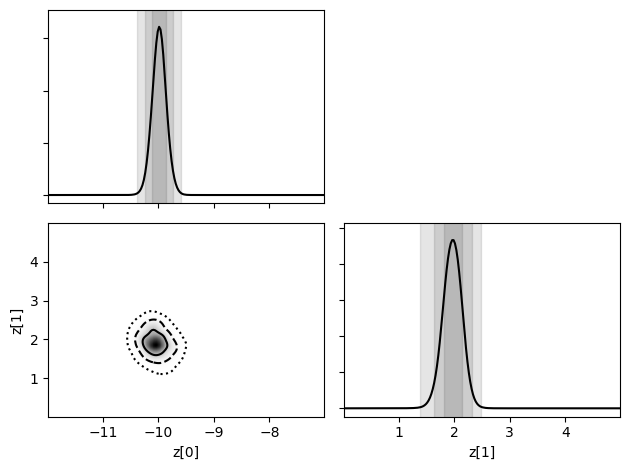

In [8]:
swyft.plot_corner(predictions, ['z[0]', 'z[1]'], bins = 200, smooth = 3);
plt.show()

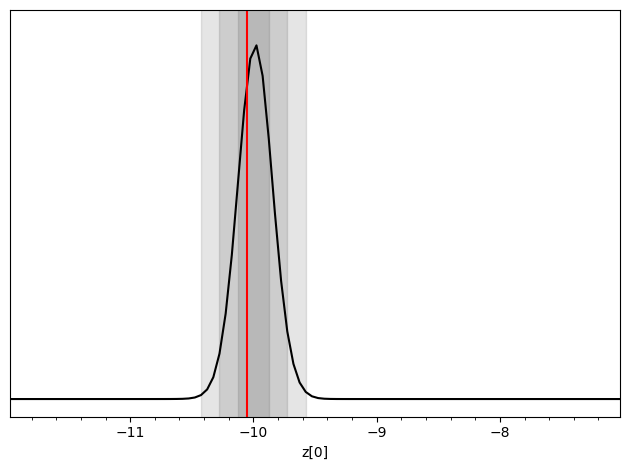

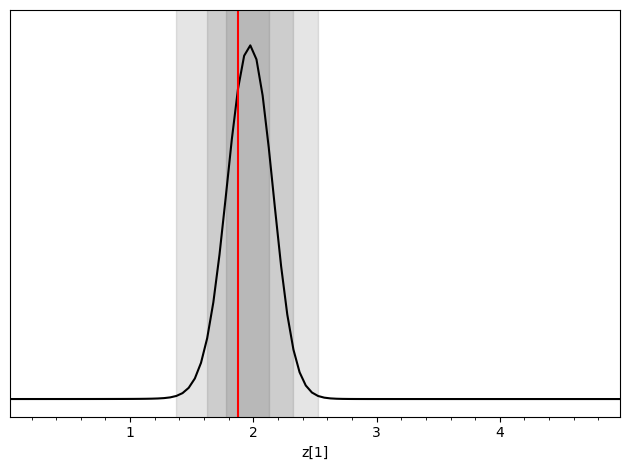

In [9]:
swyft.plot_posterior(predictions, 'z[0]', smooth=2);
plt.axvline(obs['z'][0], color="red")
plt.show()

swyft.plot_posterior(predictions, 'z[1]', smooth=2);
plt.axvline(obs['z'][1], color="red")
plt.show()
